# Intro to  Neural Networks with PyTorch
## Task 3 – Build a Custom Dataset Class + Data Ablation (CIFAR-10)

**Objective:** To implement data ablation and capture generalization gap to see if data augmentation prevents overfitting.

**Dataset + Split:** CIFAR-10 from torchvision (60,000 color images (32×32)). 50,000 images for training set with exactly 5000 per class, 10,000 for test set with exactly 1000 per class.

**Model Used:** CNN

### Import and Preprocess Dataset

In [23]:
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# Find mean and standard deviation of dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=50000) # Entire training dataset
images, _ = next(iter(loader)) # images, _ => images, labels
mean, std = images.mean([0,2,3]), images.std([0,2,3]) # Ignore dimension 1 so that mean and std are computed separately for each channel
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465]), Std: tensor([0.2470, 0.2435, 0.2616])


In [24]:
# Define class to create small random cutouts in image
# torchvision.transforms.Compose([...]) expects transforms to be callable objects
class Cutout:
  def __init__(self, size=8, prob=0.5): # Size of square cutout (8x8 pixels) and probability that cutout is applied
    self.size = size
    self.prob = prob

  def __call__(self, x): # x is a tensor of shape (c, h, w) => channels, height, width
    if random.random() > self.prob: # Apply cutout only if random probability is greater than p
      return x

    _, h, w = x.shape # Height and width of tensor
    # Define centre of square
    cy = random.randint(0, h-1)
    cx = random.randint(0, w-1)
    # Define bounding box of cutout
    s = self.size  
    y1 = max(0, cy - s//2)
    y2 = min(h, cy + s//2)
    x1 = max(0, cx - s//2)
    x2 = min(w, cx + s//2)
    # Create cutout by masking all channels
    x[:, y1:y2, x1:x2] = 0.0
    return x

In [25]:
# Function to apply transform to training set based on policy selected
def apply_train_transform(policy):
  light = [
      transforms.RandomCrop(32, padding=4), # Simulates translation; final image size = 32
      transforms.RandomHorizontalFlip(p=0.5),
  ]

  if policy == "none":
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
  if policy == "light":
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        *light,
    ])
  if policy == "light+jitter":
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        *light,
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ])
  if policy == "light+cutout":
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        *light,
        Cutout(size=8, prob=0.5),
    ])
  raise ValueError(f"Invalid policy: {policy}")


# Transform for validation, test sets
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [26]:
# Define function to make train/val split and return set indices
def create_train_val_split(seed=40, val_size=5000):
  rng = np.random.default_rng(seed) # Random number generator object
  indices = np.arange(50000) # Total train set indices
  rng.shuffle(indices) # Shuffle indices randomly
  val_indices = indices[:val_size].tolist() # First 5000 indices as val_indices
  train_indices = indices[val_size:].tolist()
  return train_indices, val_indices

In [27]:
# Define dataset class to apply augmentation according to the chosen policy only for training set
class CIFAR10DatasetClass(Dataset):
  def __init__(self, split, indices, policy):
    assert split in ["train", "val", "test"]
    self.split = split
    self.indices = indices
    self.policy = policy

    train_flag = (split != "test")
    self.base_dataset = datasets.CIFAR10(root='./data', train=train_flag, download=True)

    self.class_names = self.base_dataset.classes
    self.train_transform = apply_train_transform(policy) # Apply train transform according to policy
    self.eval_transform = eval_transform # Apply val/test transform

  def __len__(self): # Get length of indices for train/val, use full dataset for test
    return len(self.indices) if self.indices is not None else len(self.base_dataset)

  def __getitem__(self, i): # Fetch images and apply augmentation if required
    idx = self.indices[i] if self.indices is not None else i # Indices if train/val or else full dataset for test
    img, label = self.base_dataset[idx] # Get images and labels
    if self.split == "train":
      img = self.train_transform(img) # Apply augmentation to train images
    else:
      img = self.eval_transform(img) # Apply deterministic transform for val/test images
    return {"image": img, "label": int(label)} # Return dictionary of transformed images and labels

In [28]:
def get_loaders(policy, seed=40, batch_size=128):
  train_indices, val_indices = create_train_val_split(seed=seed, val_size=5000)

  train_ds = CIFAR10DatasetClass(split="train", indices=train_indices, policy=policy)
  val_ds = CIFAR10DatasetClass(split="val", indices=val_indices, policy="none")
  test_ds = CIFAR10DatasetClass(split="test", indices=None, policy="none")

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader, train_ds.class_names

### CNN Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    # DEFINE NETWORK
    def __init__(self, num_classes=10, dropout=0.3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # [B,32,32,32]; 32 filters are learned, each representing a different local pattern
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # [B,32,32,32]
            nn.ReLU(),
            nn.MaxPool2d(2), # [B,32,16,16], because 2x2 window for pooling

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B,64,16,16]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # [B,64,16,16]
            nn.ReLU(),
            nn.MaxPool2d(2), # [B,64,8,8]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # [B, 64*8*8] => [B,4096]
            nn.Linear(in_features= 64 * 8 * 8, out_features=256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes) # logits: [B,10]
        )

    # DEFINE FLOW THROUGH NETWORK
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [31]:
# Loss, Optimizer, Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(dropout=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [32]:
# Define evaluator for ACC
def evaluate(loader, model, criterion, device):
    model.eval() # Switches model to evaluation mode => Dropout is disabled, BatchNorm uses stored statistics
    # Initialize variables
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = [] # For confusion matrix
    all_labels = []

    with torch.no_grad(): # Turns off gradient tracking since no backpropagation is used
        for batch in loader:
            xb, yb = batch["image"].to(device), batch["label"].to(device) # Move tensors to same device
            logits = model(xb) # Forward pass to get logits
            loss = criterion(logits, yb) # Calculate CrossEntropyLoss
            preds = torch.argmax(logits, dim=1) # Find maximum value of logit => Predicted class (Shape: [B])

            all_preds.append(preds.cpu()) # For confusion matrix
            all_labels.append(yb.cpu())

            total_loss += loss.item() * xb.size(0) # Batch loss
            total_correct += (preds == yb).sum().item()
            total_samples += xb.size(0)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    avg_loss = total_loss / total_samples # Average loss per sample this epoch
    avg_acc = total_correct / total_samples # Average accuracy
    return avg_loss, avg_acc, all_preds, all_labels

### Training, Validation and Testing

In [34]:
import copy

# Function to train and validate for a single policy
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, max_epochs=10):
  best_state = None
  best_val_acc = -1.0

  # For plotting
  train_loss_hist = []
  train_acc_hist  = []
  val_loss_hist   = []
  val_acc_hist    = []

  for epoch in range(1, max_epochs + 1):
      model.train()
      running_loss = 0.0
      running_correct = 0
      running_total = 0

      # TRAINING
      for batch in train_loader:
          xb, yb = batch["image"].to(device), batch["label"].to(device)
          optimizer.zero_grad(set_to_none=True) # Reset gradients from previous step

          logits = model(xb) # Forward pass
          loss = criterion(logits, yb) # Compute CrossEntropy Loss
          loss.backward() # Backpropagate to compute gradients of loss w.r.t. every trainable parameter
          optimizer.step() # Update weights using AdamW

          running_loss += loss.item() * xb.size(0) # Update batch loss
          preds = logits.argmax(dim=1) # Find predictions
          running_correct += (preds == yb).sum().item() # Correct predictions
          running_total += xb.size(0) # Total samples

      train_loss = running_loss / running_total
      train_acc  = running_correct / running_total

      # VALIDATION
      val_loss, val_acc, _, _ = evaluate(val_loader, model, criterion, device)

      # For plotting
      train_loss_hist.append(train_loss)
      train_acc_hist.append(train_acc)
      val_loss_hist.append(val_loss)
      val_acc_hist.append(val_acc)

      # Checkpoint if val accuracy improves
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_state = copy.deepcopy(model.state_dict()) # Save best weights

      print(f"Epoch {epoch:02d} | "
            f"train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

  # After training, load best model
  if best_state is not None:
      model.load_state_dict(best_state)

  return train_acc, best_val_acc, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist

In [35]:
# All augmentation policies
policies = ["none", "light", "light+jitter", "light+cutout"]

results = []
loss_curves = {} # For plotting
acc_curves = {}

In [36]:
# Training and validation for all policies
for policy in policies:
  print("\n" + "="*60)
  print(f"Policy: {policy}")
  print("="*60 + "\n")

  train_loader, val_loader, test_loader, class_names = get_loaders(policy)

  model = CNN(dropout=0.3).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

  train_acc_last, best_val_acc, train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_and_validate(
      model, train_loader, val_loader, criterion, optimizer, device, max_epochs=10
  )

  test_loss, test_acc, _, _ = evaluate(test_loader, model, criterion, device)
  gap = train_acc_last - best_val_acc

  results.append((policy, train_acc_last, best_val_acc, test_acc, gap))
  loss_curves[policy] = (train_loss_hist, val_loss_hist)
  acc_curves[policy] = (train_acc_hist, val_acc_hist)

  print(f"\nTest Acc={test_acc:.3f} | Test Loss={test_loss:.4f}")
  print(f"Gap: {gap:.4f}")


Policy: none

Epoch 01 | train_loss=1.5002 | train_acc=0.4535 | val_loss=1.1428 | val_acc=0.5890
Epoch 02 | train_loss=1.0584 | train_acc=0.6236 | val_loss=0.9563 | val_acc=0.6620
Epoch 03 | train_loss=0.8649 | train_acc=0.6968 | val_loss=0.8581 | val_acc=0.7012
Epoch 04 | train_loss=0.7163 | train_acc=0.7491 | val_loss=0.7602 | val_acc=0.7376
Epoch 05 | train_loss=0.6101 | train_acc=0.7864 | val_loss=0.7400 | val_acc=0.7484
Epoch 06 | train_loss=0.5181 | train_acc=0.8178 | val_loss=0.7284 | val_acc=0.7558
Epoch 07 | train_loss=0.4371 | train_acc=0.8441 | val_loss=0.7777 | val_acc=0.7620
Epoch 08 | train_loss=0.3581 | train_acc=0.8725 | val_loss=0.8082 | val_acc=0.7582
Epoch 09 | train_loss=0.3032 | train_acc=0.8922 | val_loss=0.8517 | val_acc=0.7558
Epoch 10 | train_loss=0.2662 | train_acc=0.9048 | val_loss=0.8607 | val_acc=0.7574

Test Acc=0.755 | Test Loss=0.7666
Gap: 0.1428

Policy: light

Epoch 01 | train_loss=1.6337 | train_acc=0.3970 | val_loss=1.2944 | val_acc=0.5328
Epoch 02 

In [50]:
import pandas as pd


df = pd.DataFrame(results, columns=["policy", "train_acc_last", "best_val_acc", "test_acc", "gen_gap"])
df.sort_values("best_val_acc", ascending=False)

,policy,train_acc_last,best_val_acc,test_acc,gen_gap
1,light,0.757511,0.7844,0.7851,-0.026889
3,light+cutout,0.743267,0.7694,0.7695,-0.026133
0,none,0.904844,0.7620,0.7555,0.142844
2,light+jitter,0.615622,0.5446,0.5651,0.071022


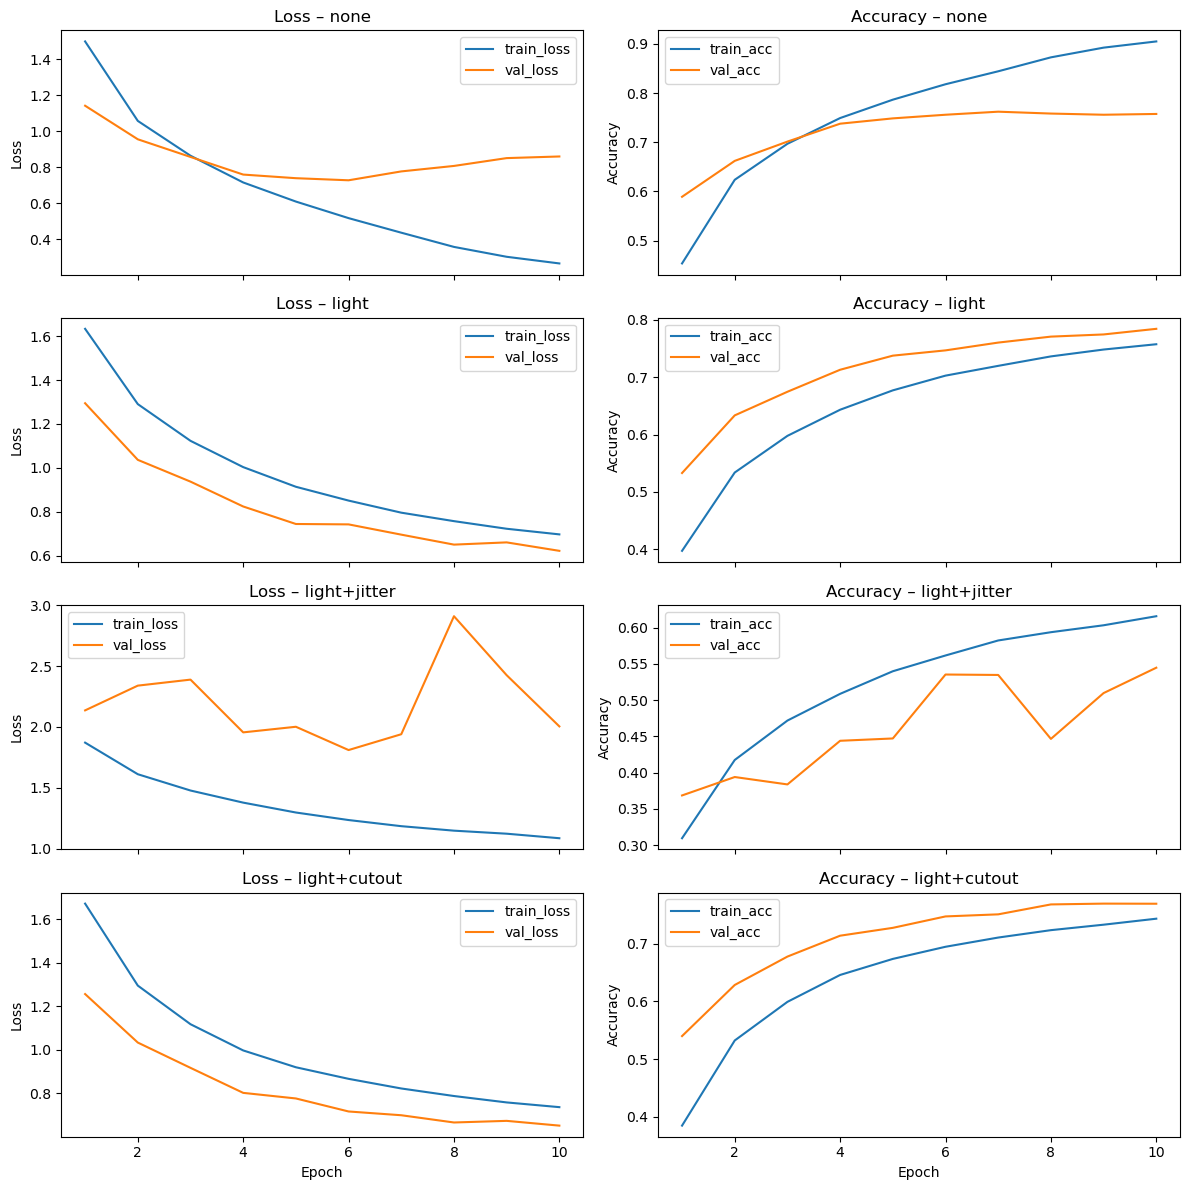

In [59]:
# Plotting loss and accuracy
import matplotlib.pyplot as plt

policies = list(loss_curves.keys()) # For maintaining same order
n = len(policies) # n = 4

fig, axes = plt.subplots(n, 2, figsize=(12, 3*n), sharex=True) # Sharex = same x-axis

epochs = range(1, len(next(iter(loss_curves.values()))[0]) + 1)

for i, pol in enumerate(policies):
    train_l, val_l = loss_curves[pol]
    train_a, val_a = acc_curves[pol]

    # Loss
    ax_loss = axes[i, 0]
    ax_loss.plot(epochs, train_l, label="train_loss")
    ax_loss.plot(epochs, val_l, label="val_loss")
    ax_loss.set_title(f"Loss – {pol}")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()

    # Accuracy
    ax_acc = axes[i, 1]
    ax_acc.plot(epochs, train_a, label="train_acc")
    ax_acc.plot(epochs, val_a, label="val_acc")
    ax_acc.set_title(f"Accuracy – {pol}")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()

# X label only on bottom row
axes[-1, 0].set_xlabel("Epoch")
axes[-1, 1].set_xlabel("Epoch")

plt.tight_layout()
plt.show()